In [10]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

random forest models modified. changed criterion to absolute error

In [11]:
def add_t_minus(df, n):
    if n == 0:
        return df
    df_res = df.copy()
    for i in range(1,n+1):
        df_shifted = df.shift(i)
        for cname in df_shifted.columns:
            df_shifted.rename(columns = {cname:cname+'_'+str(i)}, inplace = True)
        df_res = df_res.join(df_shifted)
    df_res = df_res.interpolate(method='spline', limit_direction='backward', order=1)
    return df_res

def sj_preprocess_data(features, labels=None, tminus=0):
    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="spline", order=1)
    
    if labels is not None:
        nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features, tminus)


def iq_preprocess_data(features, labels=None, tminus=0):
    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="spline", order=1)
    
    if labels is not None:
        nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features, tminus)



def get_data(features_path, labels_path=None, sj_tminus=0, iq_tminus=0):
    if labels_path is not None:
        labels = pd.read_csv(labels_path,
                           index_col=[0,1,2])

    features = pd.read_csv(features_path,
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

    # Separate data for San Juan
    sj_features = features.loc['sj']
    if labels_path is not None:
        sj_labels = labels.loc['sj']

    # Separate data for Iquitos
    iq_features = features.loc['iq']
    if labels_path is not None:
        iq_labels = labels.loc['iq']

    if labels_path is not None:
        sj_f, sj_l = sj_preprocess_data(sj_features, sj_labels, sj_tminus)
        iq_f, iq_l = iq_preprocess_data(iq_features, iq_labels, iq_tminus)
        return sj_f, sj_l, iq_f, iq_l

    return sj_preprocess_data(sj_features, None, sj_tminus), iq_preprocess_data(iq_features, None, iq_tminus)


In [12]:
sj_tminus = 2
iq_tminus = 2
sj_X_train, sj_y_train, iq_X_train, iq_y_train = get_data('dengue_features_train.csv',
                                                        'dengue_labels_train.csv',
                                                        sj_tminus=sj_tminus,
                                                        iq_tminus=iq_tminus,
                                                        )

# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

sj_X_train, sj_y_train = preprocess_data(sj_train_features,sj_train_labels)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

iq_X_train, iq_y_train = preprocess_data(iq_train_features,iq_train_labels)

In [13]:
#split data in train and test
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(
    sj_X_train, sj_y_train, test_size=0.3, shuffle=False)


iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(
iq_X_train, iq_y_train, test_size=0.3, shuffle=False)

#remove everythin before 2002, it doesnt seem to have any value
iq_X_train = iq_X_train.loc['2002-01-01':]
iq_y_train = iq_y_train.loc['2002-01-01':]


In [14]:
sj_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,655.0,26.810687,14.858483,1.000000,14.000000,27.000000,40.000000,53.000000
ndvi_ne,655.0,0.085308,0.085051,-0.290200,0.042304,0.082313,0.120275,0.446267
ndvi_nw,655.0,0.096682,0.078717,-0.130950,0.050250,0.090200,0.134000,0.437100
ndvi_se,655.0,0.181044,0.054837,0.036000,0.146207,0.178579,0.212529,0.393129
ndvi_sw,655.0,0.168472,0.055406,-0.063457,0.134221,0.169529,0.203043,0.381420
...,...,...,...,...,...,...,...,...
station_avg_temp_c_2,655.0,27.059543,1.363805,22.842857,25.928571,27.300000,28.200000,30.071429
station_diur_temp_rng_c_2,655.0,6.867930,0.820362,4.528571,6.371429,6.871429,7.385714,9.914286
station_max_temp_c_2,655.0,31.714520,1.627615,27.200000,30.600000,32.200000,32.800000,35.600000
station_min_temp_c_2,655.0,22.590341,1.485251,17.800000,21.700000,22.800000,23.900000,25.600000


In [15]:
iq_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,286.0,25.321678,14.994315,1.000000,12.250000,24.000000,38.000000,53.000000
ndvi_ne,286.0,0.266801,0.082939,0.090057,0.201750,0.264027,0.323425,0.488400
ndvi_nw,286.0,0.232114,0.075149,0.072986,0.174711,0.224271,0.284818,0.428771
ndvi_se,286.0,0.246971,0.075359,0.029880,0.192386,0.244057,0.299146,0.473400
ndvi_sw,286.0,0.260263,0.081016,0.064743,0.205636,0.258582,0.315911,0.493443
...,...,...,...,...,...,...,...,...
station_avg_temp_c_2,286.0,27.599492,0.911045,21.400000,27.225000,27.650000,28.225000,30.800000
station_diur_temp_rng_c_2,286.0,10.286003,1.504059,5.200000,9.296174,10.166667,11.161828,15.800000
station_max_temp_c_2,286.0,33.917380,1.263326,30.100000,33.125000,33.800000,34.500000,42.200000
station_min_temp_c_2,286.0,21.435094,1.300614,16.800000,20.800000,21.700000,22.400000,24.200000


In [16]:
# compute the correlations
sj_correlations = sj_X_train.corr()
iq_correlations = iq_X_train.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

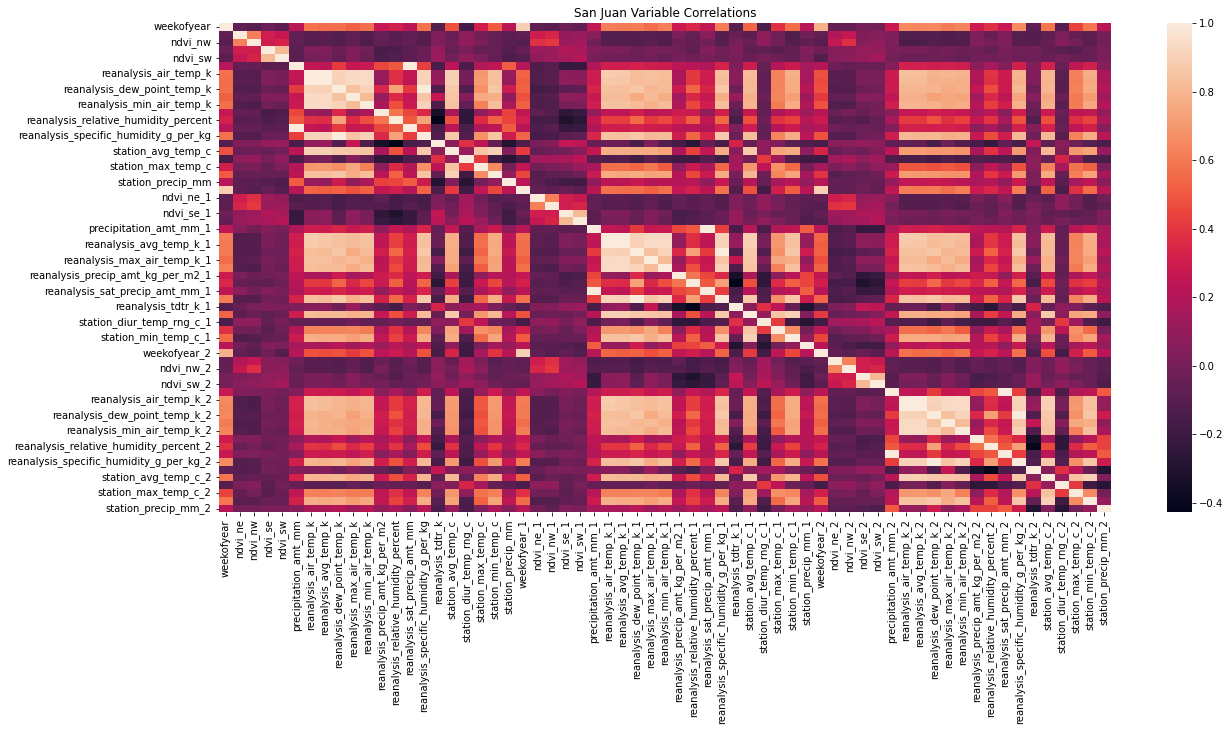

In [17]:
plt.rcParams["figure.figsize"] = (20,9)

# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

In [18]:
'''sj_rf = RandomForestRegressor(  n_estimators = 100, 
                                min_samples_leaf=25, 
                                criterion='absolute_error',
                                max_depth = 4)'''

sj_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=5,
                                criterion='squared_error',
                                )                               
sj_rf.fit(sj_X_train, sj_y_train)
print(mean_absolute_error(sj_y_train, sj_rf.predict(sj_X_train)))
print(mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))

14.768405487148224
22.338626899436246


In [19]:
sj_rf.feature_importances_

array([0.09916608, 0.01053303, 0.05663395, 0.02710074, 0.01576201,
       0.00324969, 0.00384626, 0.00094979, 0.02480752, 0.00330214,
       0.00199175, 0.0110117 , 0.01407911, 0.00231067, 0.03258256,
       0.01337644, 0.00688969, 0.00270493, 0.04420645, 0.00833209,
       0.00493705, 0.03491818, 0.00981983, 0.10834198, 0.00981906,
       0.01287013, 0.0018866 , 0.00347261, 0.00176665, 0.01259218,
       0.00472636, 0.001255  , 0.01544102, 0.00638997, 0.00196302,
       0.02036806, 0.00933797, 0.0064803 , 0.00316224, 0.01998741,
       0.00659492, 0.00468149, 0.07083691, 0.01460729, 0.05311519,
       0.01697306, 0.01465203, 0.00131332, 0.00168048, 0.00202114,
       0.02914522, 0.00745823, 0.00307686, 0.00579014, 0.00885436,
       0.0026912 , 0.03374021, 0.0056927 , 0.01123915, 0.00466319,
       0.01828625, 0.00515595, 0.00535848])

<AxesSubplot:ylabel='cols'>

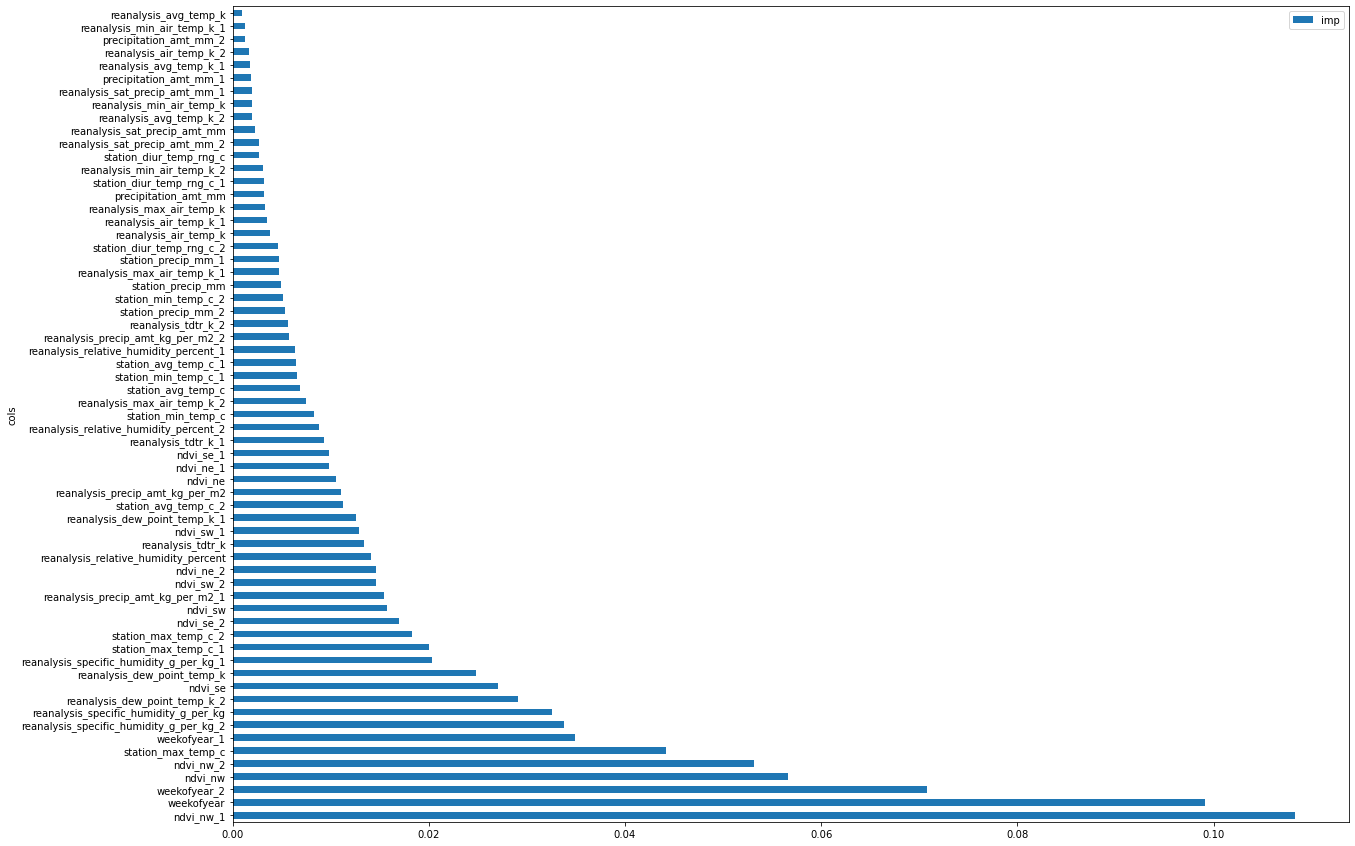

In [20]:
plt.rcParams["figure.figsize"] = (20,15)
(pd.DataFrame(dict(cols=sj_X_train.columns, imp=sj_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [21]:
iq_rf =  RandomForestRegressor( n_estimators = 100, 
                                min_samples_leaf=5, 
                                criterion='squared_error',
                                )

'''iq_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=25,
                                criterion='absolute_error',)  '''
iq_rf.fit(iq_X_train, iq_y_train)
print(mean_absolute_error(iq_y_train, iq_rf.predict(iq_X_train)))
print(mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

3.689446226119195
7.687106113966902


In [22]:
iq_rf.feature_importances_

array([0.14884427, 0.01137309, 0.01285273, 0.00710144, 0.00483419,
       0.01124298, 0.00940203, 0.01594874, 0.02090407, 0.00242853,
       0.01138854, 0.02245034, 0.00402599, 0.01383859, 0.04128096,
       0.00673148, 0.00732815, 0.00808621, 0.01387324, 0.01636805,
       0.01604258, 0.0226851 , 0.0085969 , 0.0324409 , 0.00699224,
       0.00593685, 0.00163888, 0.01187726, 0.00991032, 0.00494394,
       0.01336311, 0.02905857, 0.00203596, 0.00446296, 0.00768634,
       0.01469746, 0.00914837, 0.01517327, 0.00348561, 0.0124642 ,
       0.0060826 , 0.02089486, 0.02933568, 0.03731765, 0.01639123,
       0.01781965, 0.00984497, 0.00343773, 0.00691488, 0.01991131,
       0.00287835, 0.00933326, 0.08605038, 0.00790236, 0.00390588,
       0.00125976, 0.00742838, 0.00846344, 0.01258803, 0.00620048,
       0.04259824, 0.01035682, 0.01013961])

<AxesSubplot:ylabel='cols'>

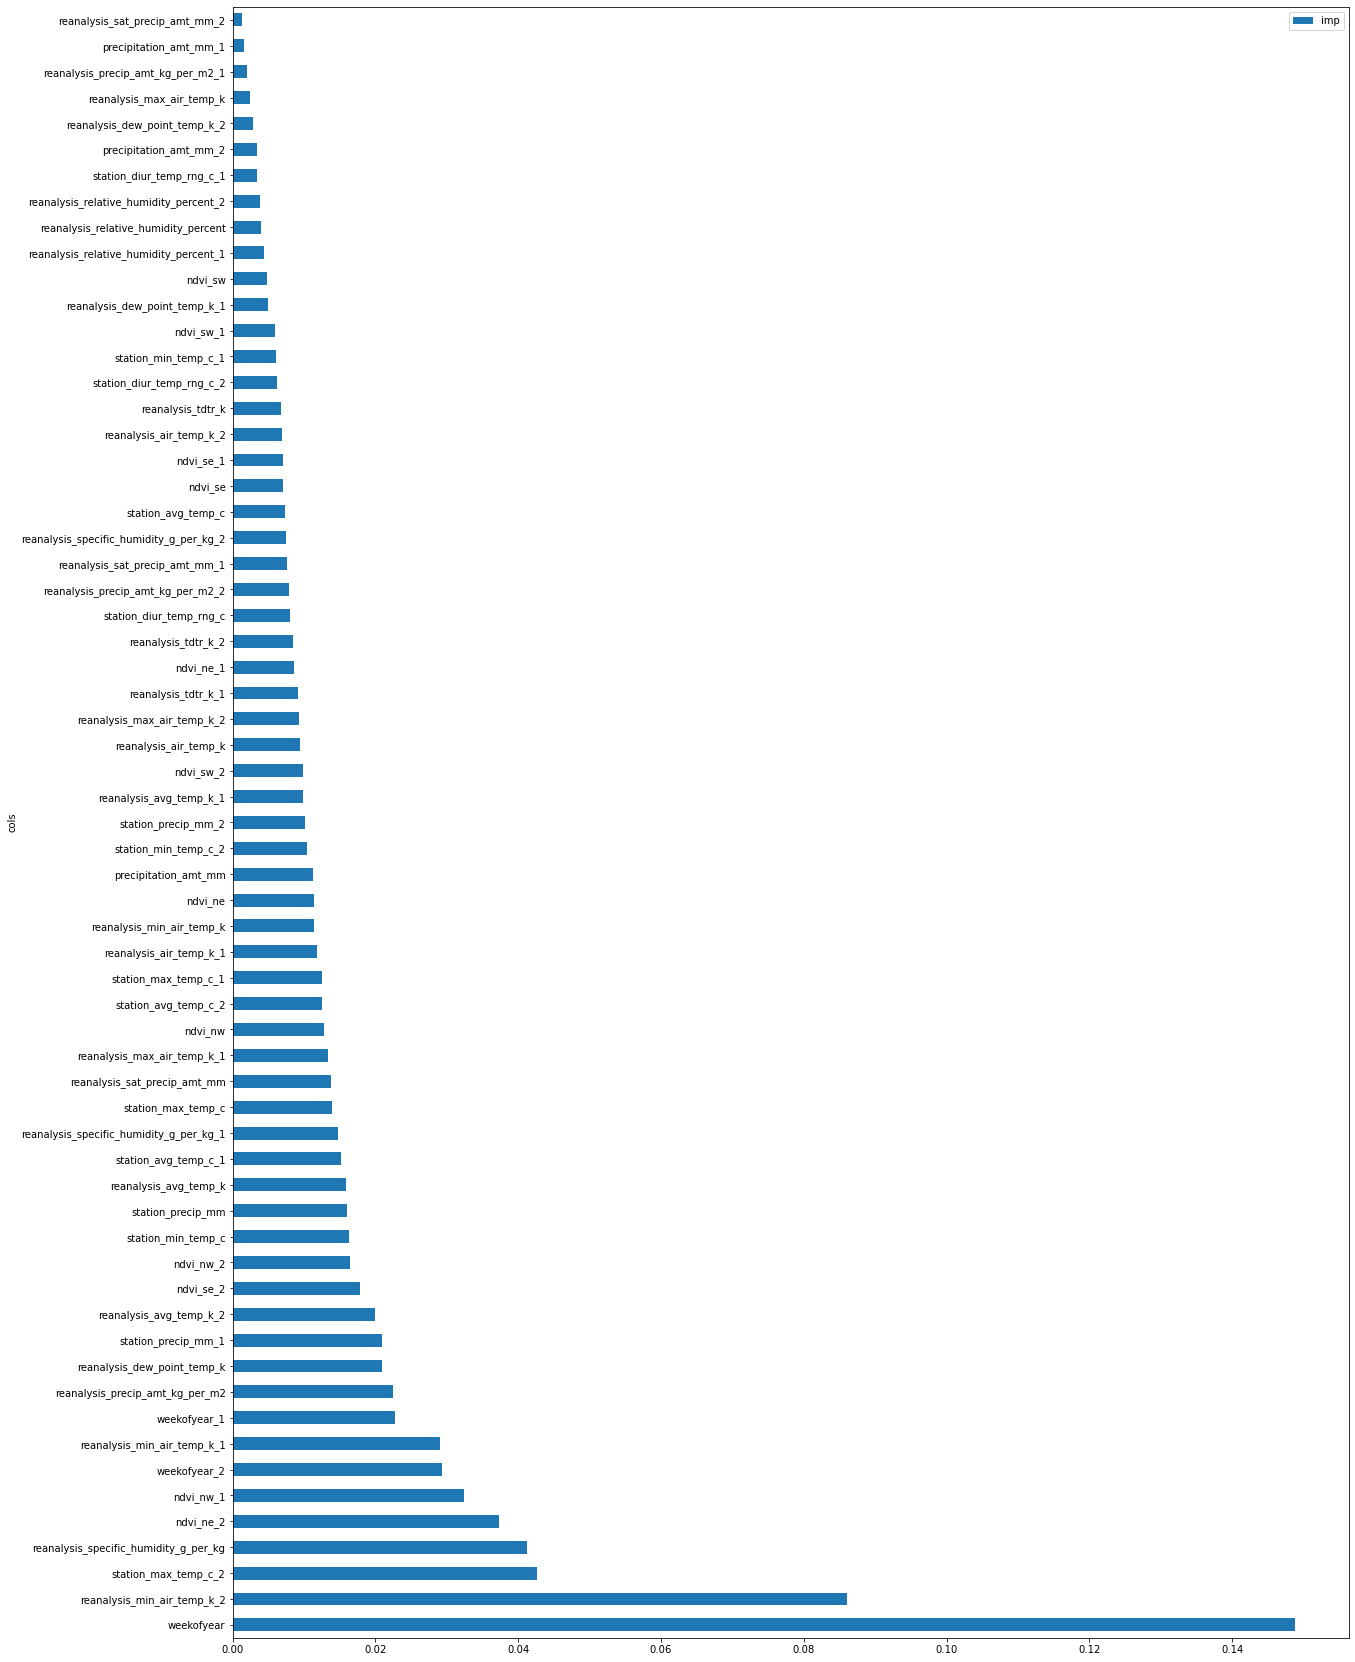

In [23]:
plt.rcParams["figure.figsize"] = (20,30)
(pd.DataFrame(dict(cols=iq_X_train.columns, imp=iq_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

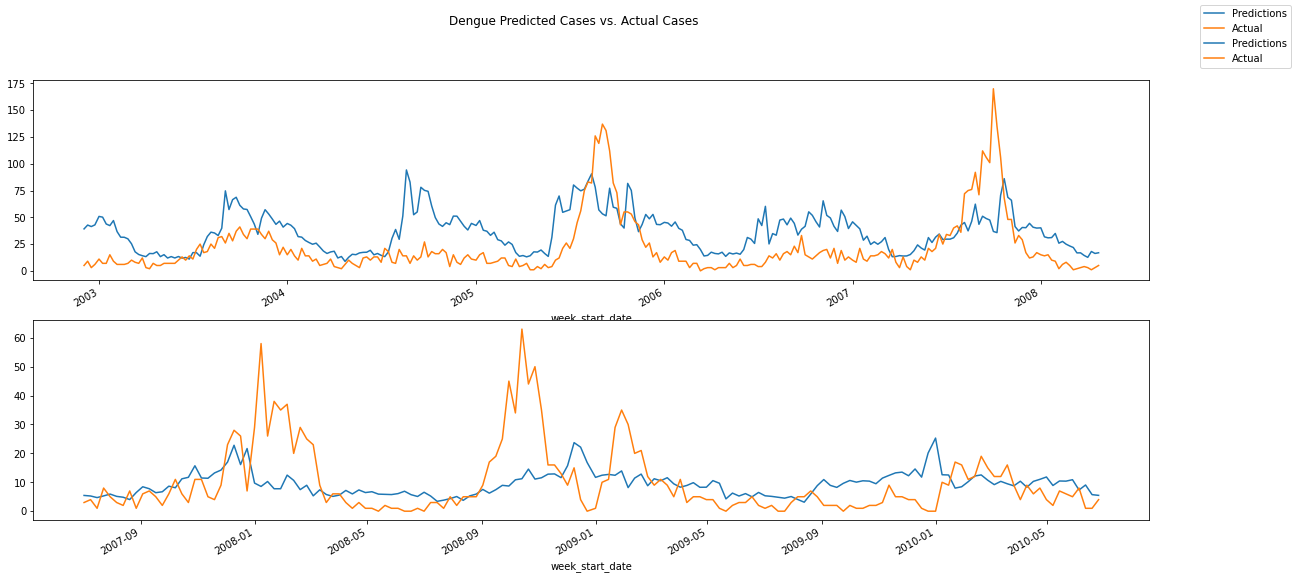

In [24]:
plt.rcParams["figure.figsize"] = (20,9)
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_X_test['fitted'] = sj_rf.predict(sj_X_test)
sj_X_test.fitted.plot(ax=axes[0], label="Predictions")
sj_y_test.plot(ax=axes[0], label="Actual")

iq_X_test['fitted'] = iq_rf.predict(iq_X_test)
iq_X_test.fitted.plot(ax=axes[1], label="Predictions")
iq_y_test.plot(ax=axes[1], label="Actual")

figs.suptitle("Dengue Predicted Cases vs. Actual Cases")
figs.legend()

In [25]:
sj_X_test.drop('fitted',axis=1,inplace=True)
iq_X_test.drop('fitted',axis=1,inplace=True)

In [26]:
#submit data
sj_X_valid, iq_X_valid = get_data('dengue_features_test.csv',
                                    sj_tminus=sj_tminus,
                                    iq_tminus=iq_tminus,
                                    ) 

In [27]:
sj_X_valid

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_2,reanalysis_relative_humidity_percent_2,reanalysis_sat_precip_amt_mm_2,reanalysis_specific_humidity_g_per_kg_2,reanalysis_tdtr_k_2,station_avg_temp_c_2,station_diur_temp_rng_c_2,station_max_temp_c_2,station_min_temp_c_2,station_precip_mm_2
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,18,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,...,32.716847,83.485995,209.747982,16.792062,2.821446,29.001057,5.973341,32.088808,23.437975,145.804033
2008-05-06,19,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,...,29.057876,81.618162,144.105476,16.844368,2.819657,28.916160,5.974662,32.179863,23.489394,109.695779
2008-05-13,20,-0.001500,0.061357,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,...,25.370000,78.781429,78.600000,15.918571,3.128571,26.528571,7.057143,33.300000,21.700000,75.200000
2008-05-20,21,0.072478,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,...,21.830000,78.230000,12.560000,15.791429,2.571429,26.071429,5.557143,30.000000,22.200000,34.300000
2008-05-27,22,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,...,4.120000,78.270000,3.660000,16.674286,4.428571,27.928571,7.785714,32.800000,22.800000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,13,-0.087400,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,301.3,...,13.500000,72.562857,0.000000,13.458571,2.128571,25.357143,5.471429,30.000000,21.700000,17.100000
2013-04-02,14,-0.203250,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,...,4.800000,68.181429,0.000000,12.705714,3.057143,25.842857,6.471429,29.400000,21.700000,4.800000
2013-04-09,15,-0.117600,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,301.5,...,2.550000,78.780000,30.340000,15.985714,3.314286,27.542857,7.942857,33.900000,22.800000,3.500000


In [28]:
iq_X_valid

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_2,reanalysis_relative_humidity_percent_2,reanalysis_sat_precip_amt_mm_2,reanalysis_specific_humidity_g_per_kg_2,reanalysis_tdtr_k_2,station_avg_temp_c_2,station_diur_temp_rng_c_2,station_max_temp_c_2,station_min_temp_c_2,station_precip_mm_2
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,26,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,...,83.321311,109.419792,195.658711,15.802975,10.085689,27.617109,9.453571,33.692333,19.227739,15.499609
2010-07-09,27,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,...,58.673062,100.967436,138.936547,15.887532,9.914065,27.616245,9.747160,33.792276,19.300023,13.336138
2010-07-16,28,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,...,34.110000,92.581429,82.290000,17.654286,9.428571,27.440000,10.760000,33.800000,21.500000,11.200000
2010-07-23,29,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,...,9.100000,83.885714,25.300000,16.320000,10.157143,27.025000,9.625000,33.000000,21.200000,8.900000
2010-07-30,30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,...,61.090000,92.057143,62.140000,18.030000,9.557143,26.950000,10.350000,33.400000,21.600000,22.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,22,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,...,105.700000,95.338571,46.270000,18.038571,6.400000,28.233333,9.400000,34.100000,21.400000,38.600000
2013-06-04,23,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,...,124.200000,94.740000,87.290000,17.382857,6.700000,26.633333,8.900000,32.800000,21.800000,97.300000
2013-06-11,24,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,...,67.600000,89.990000,41.120000,17.185714,10.100000,27.400000,9.050000,32.600000,21.800000,33.000000


In [29]:
b = sj_rf.predict(sj_X_valid).astype(int)
sj_predictions = sj_rf.predict(sj_X_valid).astype(int)
iq_predictions = iq_rf.predict(iq_X_valid).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

In [30]:
sj_predictions, iq_predictions

(array([ 17,  19,  18,  19,  19,  27,  17,  21,  16,  25,  16,  20,  24,
         33,  49,  63,  61,  70,  86,  90,  87,  71,  70,  76,  58,  53,
         43,  48,  49,  48,  43,  42,  52,  43,  38,  35,  37,  34,  34,
         39,  32,  27,  20,  18,  17,  16,  16,  16,  15,  16,  17,  17,
         14,  12,  17,  18,  15,  14,  10,  14,  17,  16,  19,  20,  39,
         38,  59,  50,  44,  53,  74,  64,  64,  59,  70,  70,  74,  76,
         98,  72,  59,  42,  39,  46,  42,  40,  43,  44,  51,  54,  47,
         42,  40,  34,  32,  36,  38,  31,  22,  20,  14,  22,  12,  13,
         14,  24,  20,  22,  13,  42,  61,  75,  86,  84,  84,  80,  83,
         87,  78,  86,  82,  87, 101, 100,  90,  63,  47,  44,  75,  59,
         56,  39,  50,  51,  52,  41,  35,  41,  32,  36,  38,  38,  37,
         40,  33,  25,  26,  24,  23,  17,  13,  12,  12,  11,  13,  12,
         12,  14,  18,  19,  15,  19,  24,  50,  56,  70,  78,  78,  60,
         72,  47,  79,  59,  78,  65,  59,  49,  63

In [31]:
print('sj', mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))
print('iq', mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

sj 22.338626899436246
iq 7.687106113966902


sj 17.274501779359433
iq 7.246260500628908

In [32]:
sj_X_test

,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_2,reanalysis_relative_humidity_percent_2,reanalysis_sat_precip_amt_mm_2,reanalysis_specific_humidity_g_per_kg_2,reanalysis_tdtr_k_2,station_avg_temp_c_2,station_diur_temp_rng_c_2,station_max_temp_c_2,station_min_temp_c_2,station_precip_mm_2
week_start_date,,,,,,,,,,,,,,,,,,,,,
2002-12-03,49,-0.24390,-0.120933,0.279086,0.248843,0.00,300.170000,300.314286,295.205714,302.0,...,32.30,78.605714,100.94,17.338571,2.685714,27.214286,6.842857,32.2,23.3,30.8
2002-12-10,50,-0.17430,-0.072300,0.199300,0.171300,7.32,299.892857,299.928571,294.978571,301.4,...,22.77,78.962857,11.61,17.510000,2.485714,26.985714,7.000000,32.2,21.7,28.0
2002-12-17,51,-0.04300,-0.128950,0.185414,0.208800,0.00,299.378571,299.600000,294.577143,301.2,...,5.90,74.372857,0.00,16.578571,2.714286,26.428571,7.285714,31.1,21.7,2.9
2002-12-24,52,0.03580,-0.252800,0.243433,0.136929,6.58,298.638571,298.807143,294.805714,301.1,...,7.45,74.517143,7.32,16.327143,1.771429,26.071429,6.642857,30.0,21.7,40.6
2003-01-01,1,-0.07195,-0.045250,0.230457,0.175714,0.00,298.041429,298.085714,294.381429,300.3,...,8.30,74.942857,0.00,15.918571,2.371429,25.928571,6.971429,30.6,21.7,18.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-25,13,0.07785,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,...,9.38,71.934286,0.00,13.721429,2.085714,25.328571,5.814286,28.9,22.2,4.4
2008-04-01,14,-0.03800,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,...,0.90,72.915714,0.00,13.737143,3.871429,25.200000,7.042857,30.0,20.6,0.5
2008-04-08,15,-0.15520,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,...,7.55,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8


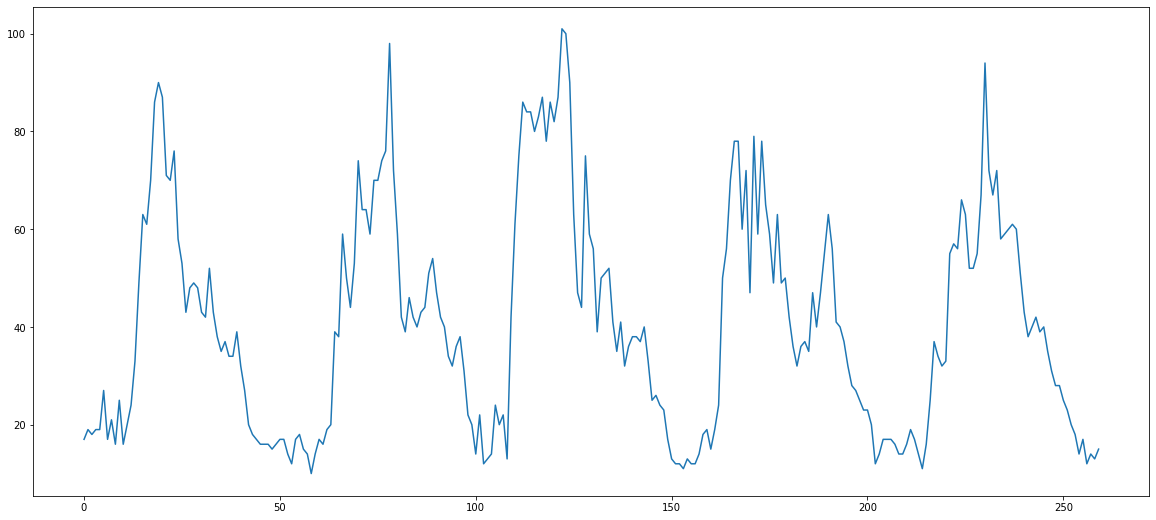

In [33]:
plt.plot(sj_predictions)

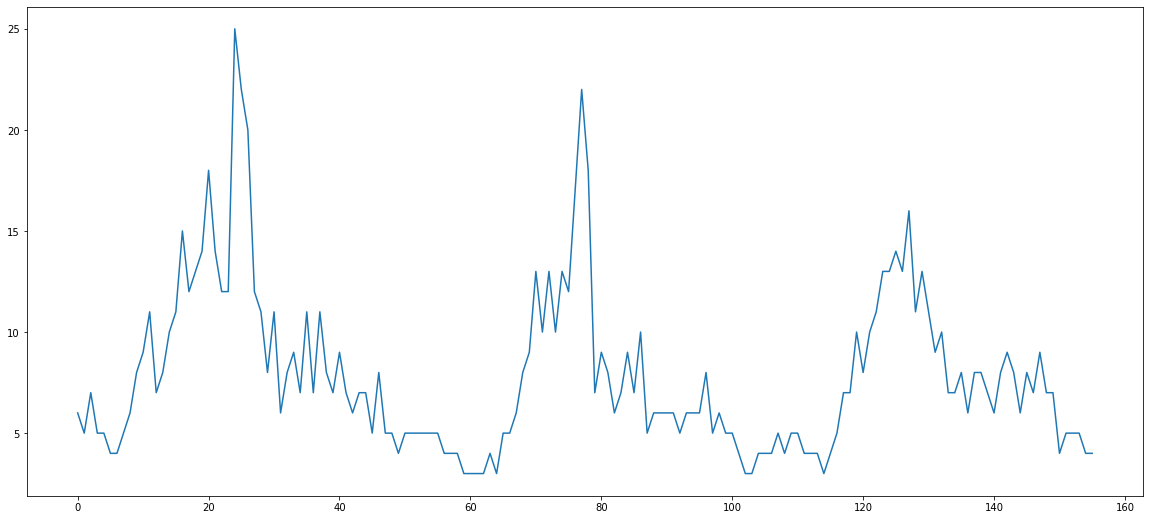

In [34]:
plt.plot(iq_predictions)